# ST446 Distributed Computing for Big Data
## Seminar class 8: scalable machine learning II
---

## Topic modeling: Latent Dirichlet Allocation

In the lectures, we learned two methods for topic modeling: Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA).
In this notebook, we demonstrate how to do topic modelling for a document corpus in PySpark using LDA. 

We show how to:
* tokenize and lemmatize textual data using the natural language tool kit (NLTK)
* convert words and documents into vector representations, specially, the use of sparse vectors
* the use of LDA to infer the latent topics of documents

We recommend running this notebook on a dataproc cluster.

## Recap

![LDA](./fig/LDA-0.png)

## Load data

In [80]:
# you should not need these commands on a correctly initialised cluster:
# # run this command in a terminal, if sklearn is not installed on your machine/compute engine:
# pip install -U scikit-learn

# # run this command in a terminal, if nltk is not installed on your machine/compute engine:
# pip install -U nltk

# # to get the stopwords dataset, use python
# >>> import nltk
# >>> nltk.download('stopwords')

In [81]:
import nltk # test
nltk.download('all') # uncomment this for the first to check that all data has already been nstalled
sc.defaultParallelism
# note that this should ouput "already up-to-date!" for every package!

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package cess_cat is already up-

6

We are downloading the standard data set 20 newsgroup, see https://scikit-learn.org/stable/datasets/index.html#newsgroups-dataset

In [82]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

documents = dataset.data

news = sc.parallelize(documents)
news.take(2)

['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
 "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't an

In [83]:
print('Number of partitions: ', news.getNumPartitions())
n = news_df_w_features.count()
print('Number of messages/documents n = ', n)

Number of partitions:  6
Number of messages/documents n =  10998


## 1. Parse the data

Here we make use of the natural language processing module `nltk`. 

Both the module and the corresponding data should have been downloaded by our custom cluster initialisation actions. See https://www.nltk.org/install.html and https://www.nltk.org/data.html for more details.

We will have to process the messages to make them amenable to analysis. Important steps include:
* Tokenisation chops text into useful units (words). 
* Lemmatisation groups together inflected words, yields their dictionary form.

In [84]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer() # see https://www.nltk.org/_modules/nltk/stem/wordnet.html for details

def get_tokens(line):
    ###
    import nltk
#     nltk.download('all')
    ###
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

news_rdd = news.map(lambda line: (1, get_tokens(line)))
news_rdd.take(1)

[(1,
  ['wondering',
   'anyone',
   'could',
   'enlighten',
   'car',
   'saw',
   'day',
   'sport',
   'car',
   'looked',
   'late',
   'early',
   'called',
   'bricklin',
   'door',
   'really',
   'small',
   'addition',
   'front',
   'bumper',
   'separate',
   'rest',
   'body',
   'know',
   'anyone',
   'tellme',
   'model',
   'name',
   'engine',
   'spec',
   'year',
   'production',
   'car',
   'made',
   'history',
   'whatever',
   'info',
   'funky',
   'looking',
   'car',
   'please',
   'email'])]

**Question**: why we add a key of `1` to all the rows?

Some of the stop words are content specific (https://en.wikipedia.org/wiki/Stop_words). Here we assume that words that appear very frequently are stop words. We use 3000 as a threshold.

In [85]:
doc_stop_words = news_rdd.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)

# doc_stop_words.collect()

doc_stop_words = doc_stop_words.filter(lambda a: a[1]>3000).map(lambda r: r[0]).collect()

# throw away stop words and words that are just single letters.
news_rdd = news_rdd.map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words and not len(w)==1])) 
#                    .filter(lambda row: len(row[1]) > 0)

news_rdd.take(1)[0][1][:10]

['wondering',
 'anyone',
 'could',
 'enlighten',
 'car',
 'saw',
 'day',
 'sport',
 'car',
 'looked']

## 2. Convert tokens into sparse vectors

In [86]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

news_df = spark.createDataFrame(news_rdd, ["dummy","words"])
news_df.cache()
news_df.take(1)

[Row(dummy=1, words=['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sport', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'door', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'email'])]

Now, we generate vectors that are essentially historgrams of word counts associated with each message, see https://spark.apache.org/docs/latest/ml-features.html#countvectorizer

In [87]:
cv = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cv_model = cv.fit(news_df)

news_df_w_features = cv_model.transform(news_df)
news_df_w_features.cache()
news_df_w_features.show(10)

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[wondering, anyon...|(30870,[0,1,32,37...|
|    1|[fair, number, br...|(30870,[18,29,37,...|
|    1|[well, folk, mac,...|(30870,[0,3,4,7,9...|
|    1|[weitek, addressp...|(30870,[29,38,118...|
|    1|[article, worldst...|(30870,[2,3,11,13...|
|    1|[course, term, mu...|(30870,[16,31,40,...|
|    1|[responded, reque...|(30870,[0,6,61,62...|
|    1|[show, much, scsi...|(30870,[8,9,10,11...|
|    1|[win, downloaded,...|(30870,[56,60,146...|
|    1|[board, year, wor...|(30870,[1,4,5,6,1...|
+-----+--------------------+--------------------+
only showing top 10 rows



### Take a look at the vocabulary
The cv model stores the vocabulary separately from the histograms of words for each document.

In [88]:
print ("Vocabulary from CountVectorizerModel is:")
print(cv_model.vocabulary[:100])
print("\n---\n")

W = len(cv_model.vocabulary)
print("Number of terms W = ", W)

Vocabulary from CountVectorizerModel is:
['could', 'year', 'system', 'new', 'make', 'say', 'file', 'good', 'may', 'well', 'problem', 'right', 'even', 'thing', 'way', 'see', 'first', 'work', 'two', 'much', 'many', 'god', 'want', 'need', 'program', 'go', 'used', 'window', 'said', 'number', 'question', 'point', 'anyone', 'something', 'take', 'come', 'since', 'please', 'information', 'drive', 'using', 'key', 'back', 'really', 'state', 'mean', 'going', 'look', 'still', 'part', 'find', 'case', 'day', 'game', 'believe', 'must', 'help', 'government', 'available', 'law', 'ca', 'last', 'thanks', 'email', 'might', 'another', 'run', 'data', 'group', 'got', 'without', 'line', 'made', 'let', 'better', 'sure', 'etc', 'read', 'give', 'never', 'set', 'space', 'fact', 'lot', 'power', 'name', 'however', 'armenian', 'card', 'support', 'list', 'car', 'version', 'around', 'tell', 'team', 'second', 'probably', 'someone', 'world']

---

Number of terms W =  30870


## 3. Latent Dirichlet Allocation

We now analyse the same dataset using Latent Dirichlet Allocation (http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf, https://spark.apache.org/docs/2.2.0/mllib-clustering.html#latent-dirichlet-allocation-lda) to find feature vectors characterizing topics of documents, and feature vectors characterizing the words of topics.

![LDA](./fig/LDA-1.png)

Note that we assume the number of topics $k$ **a priori** (hyperparameter). Here we fix $k=20$

### 3a. Batch variational inference

![LDA](./fig/LDA-2.png)

In [ ]:
from pyspark.ml.clustering import LDA

lda = LDA(k=20, maxIter=5)

lda_model = lda.fit(news_df_w_features)

The perplexity below is a measurement of how well a probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.
You can think of it as being something like $2^{-\frac{1}{N}\sum_i \log_2q(x_i)}$, where $q$ is the model for the probability and the sum goes over $N$ test samples.  It is mainly used when comparing different models.

In [ ]:
ll = lda_model.logLikelihood(news_df_w_features)

lp = lda_model.logPerplexity(news_df_w_features)

print("The lower bound on the log likelihood of the entire corpus: " + str(ll))

print("The upper bound on the perplexity: " + str(lp))

In [ ]:
# Describe topics
topics = lda_model.describeTopics(5)

print("The topics described by their top-weighted terms:")

topics.show(truncate=False)

# Shows the results
import numpy as np
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cv_model.vocabulary)[i])

### 3b. Online LDA v.s. batch LDA

![LDA](./fig/LDA-3.png)

By specify the arguments in `LDA` class, we can switch between batch LDA and online LDA:
* default: batch LDA using EM algorithm
* `optimizer='online'`: online LDA using online variational inference

here we run experiments on both algorithms and compare the results of them

In [89]:
news_train, news_test = news_df_w_features.randomSplit([9.0, 1.0], 24)

In [91]:
from pyspark.ml.clustering import LDA
import numpy as np
from time import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

def perplexity_vs_doc(lda, train, test, stage):
    testPreplexity = np.zeros(stage)
    computationTime = np.zeros(stage)
    fracs = np.linspace(0.1, 1.0, stage)
    num_repeat = 5
    for j in range(num_repeat):
        for i in range(stage):
            corpus = train.sample(False, fracs[i], 10*j)
            # Batch variational inference
            t0 = time()
            lda_model = lda.fit(corpus)
            t1 = time()
            computationTime[i] += (t1 - t0)/num_repeat
            testPreplexity[i] += lda_model.logPerplexity(test)/num_repeat
    return testPreplexity, computationTime

# set the seeds to have the same inital clustering
# batch LDA
test_preplexity_em, computation_time_em = perplexity_vs_doc(LDA(k=20, maxIter=5, seed=123), 
                                                            news_train, news_test, 10)
# online LDA
test_preplexity_online, computation_time_online = perplexity_vs_doc(LDA(k=20, maxIter=5, optimizer='online', seed=123), 
                                                                    news_train, news_test, 10)

#### testing preplexity vs training data size

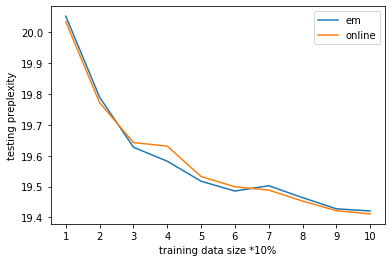

In [103]:
plt.plot(test_preplexity_em, label = "em")
plt.plot(test_preplexity_online, label = "online")
plt.xticks(np.arange(0, 10, 1), [str(i+1) for i in np.arange(0, 10, 1)])
plt.xlabel("training data size *10%")
plt.ylabel("testing preplexity")
plt.legend()
plt.show();

#### computation time vs training data size

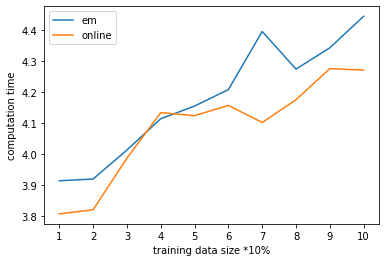

In [104]:
plt.plot(computation_time_em, label = "em")
plt.plot(computation_time_online, label = "online")
plt.xticks(np.arange(0, 10, 1), [str(i+1) for i in np.arange(0, 10, 1)])
plt.xlabel("training data size *10%")
plt.ylabel("computation time")
plt.legend()
plt.show();